In [1]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
import pathlib
import os
os.environ['VXM_BACKEND'] = 'pytorch'
from voxelmorph import networks
import nibabel as nib
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as nnf


In [2]:
[*(pathlib.Path('/data01/junyi/results/tracts_related/seg9').iterdir())]
backbone_tracts = ['AF', 'ATR', 'CA', 'CC',
                   'CG', 'CST', 'FPT', 'ICP', 'IFO', 'ILF', 'MCP', 'MLF', 'OR', 'POPT', 'SCP',]


In [3]:
from voxelmorph.py import utils

In [5]:
dice_dict1 = {}
for tract in backbone_tracts:
    dice_lst = []
    mask = [nib.load(path).get_fdata() for path in pathlib.Path('/data01/junyi/results/tracts_related/seg9').glob(f'**/{tract}*.nii.gz')]
    for i in range(10):
        for j in range(10):
            dice = utils.dice(mask[i],mask[j])[0] if i>j else 0
            dice_lst.append(dice)
    dice_dict1[tract] = np.stack(dice_lst).reshape(10,-1)

In [6]:
np.savez('dice_model1.npz',**dice_dict1)

In [7]:
dice = {}
dice['Ants']= [np.sum(value)/45 for i,value in np.load('dice_ants.npz',allow_pickle=True).items() if not i =='FX']
dice['no_TOMs']=[np.sum(value)/45 for i,value in np.load('dice_model.npz',allow_pickle=True).items()if not i =='FX']
dice['Proposed']= [np.sum(value)/45 for i,value in np.load('dice_model1.npz',allow_pickle=True).items()if not i =='FX']

In [8]:
def bar_chart(group_num,score,barWidth =0.25):
    fig,ax = plt.subplots(figsize=(8,5))
    br1 = np.arange(group_num) 
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2]
    plt.bar(br1,score['Ants'],width = barWidth, label= 'Ants')
    plt.bar(br2,score['no_TOMs'],width = barWidth, label= 'without TOMs')
    plt.bar(br3,score['Proposed'],width = barWidth, label= 'Proposed method')
    plt.xlabel('Tracts', fontweight ='bold', fontsize = 15) 
    plt.ylabel('Mean Tracts Dice Score', fontweight ='bold', fontsize = 15) 
    plt.xticks([r + barWidth for r in range(group_num)], 
            backbone_tracts)
    plt.legend(loc ='upper right', bbox_to_anchor=(0.3, 1.15))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # plt.savefig('all.png')

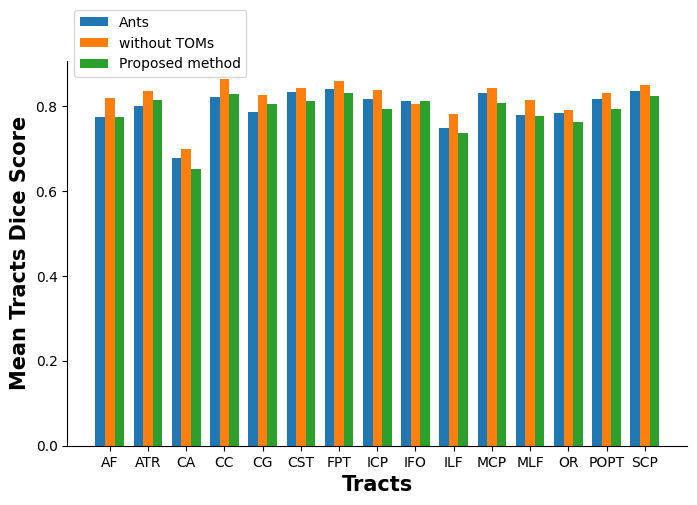

In [9]:
bar_chart(15,dice)

In [11]:
dice_dict1 = np.load('dice_modelp.npz',allow_pickle=True)
dice_dict = np.load('dice_model.npz',allow_pickle=True)

Text(0.5, 0.9, 'Dice difference of  Purposed Method and Ants')

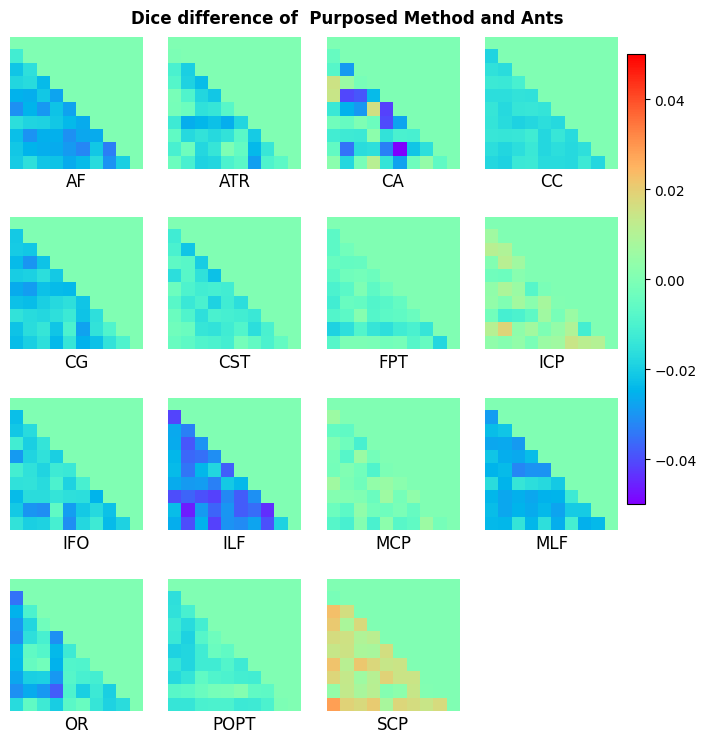

In [16]:
fig, axes = plt.subplots(4,4,figsize=(9,9))
# print(np.sum((dice_dict[tract]-dice_dict1[tract])<0))
axes = axes.flat

for i,tract in enumerate(backbone_tracts):
    im = axes[i].imshow((dice_dict1[tract]-dice_dict[tract]),vmin=-0.05,vmax=0.05,cmap='rainbow')
    axes[i].axis('off')
    axes[i].set_title(tract,y=-0.2)
axes[i+1].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81,0.35,0.02,0.5])
fig.colorbar(im,cbar_ax)
fig.suptitle('Dice difference of  Purposed Method and Ants',y=0.9,fontweight='bold')


tensor([[0.9940, 0.7810, 0.6202, 0.4559, 0.3109, 0.2173, 0.1497, 0.0966, 0.0527,
         0.0343],
        [0.7810, 0.9943, 0.8077, 0.6186, 0.4333, 0.3070, 0.2163, 0.1426, 0.0786,
         0.0500],
        [0.6202, 0.8077, 0.9946, 0.7811, 0.5763, 0.4147, 0.2917, 0.2017, 0.1190,
         0.0744],
        [0.4559, 0.6186, 0.7811, 0.9943, 0.7542, 0.5637, 0.4076, 0.2946, 0.1895,
         0.1210],
        [0.3109, 0.4333, 0.5763, 0.7542, 0.9938, 0.7573, 0.5777, 0.4407, 0.3070,
         0.2010],
        [0.2173, 0.3070, 0.4147, 0.5637, 0.7573, 0.9939, 0.7878, 0.6292, 0.4626,
         0.3132],
        [0.1497, 0.2163, 0.2917, 0.4076, 0.5777, 0.7878, 0.9944, 0.8079, 0.6195,
         0.4286],
        [0.0966, 0.1426, 0.2017, 0.2946, 0.4407, 0.6292, 0.8079, 0.9947, 0.7841,
         0.5765],
        [0.0527, 0.0786, 0.1190, 0.1895, 0.3070, 0.4626, 0.6195, 0.7841, 0.9944,
         0.7603],
        [0.0343, 0.0500, 0.0744, 0.1210, 0.2010, 0.3132, 0.4286, 0.5765, 0.7603,
         0.9938]], dtype=tor

In [12]:
def tract_distance(voxels,num_ind):
    tract_warped = voxels.reshape(num_ind,3,-1).permute(-1,0,1)
    mask = (torch.abs(tract_warped).max(-1,keepdim=True)[0] > 5e-2).float()
    overlap = ((mask @ mask.mT) > 1e-5).float()
    weight = overlap/overlap.sum(0,keepdim=True)

    top = torch.clip(tract_warped @ tract_warped.mT,min=1e-7)
    vec_len = torch.sqrt((tract_warped)**2)

    bottom = torch.clip(vec_len @ vec_len.mT,min=1e-7)

    return (top/bottom*weight).sum(0)

In [13]:
batch_size=10

In [34]:
dataset = TOMDatasetDir('../HCP_100')
data = DataLoader(dataset,batch_size=batch_size,shuffle=True)
eval_data = next(iter(data)).to('cuda:5')

with torch.no_grad():
    model.to('cuda:5').eval()
    outputs = model(eval_data)

In [33]:
tract_shape_dice(torch.stack((outputs[1][5,...],eval_data[5])),2)

tensor([[1.0000, 0.5979],
        [0.5979, 0.9999]], device='cuda:5')

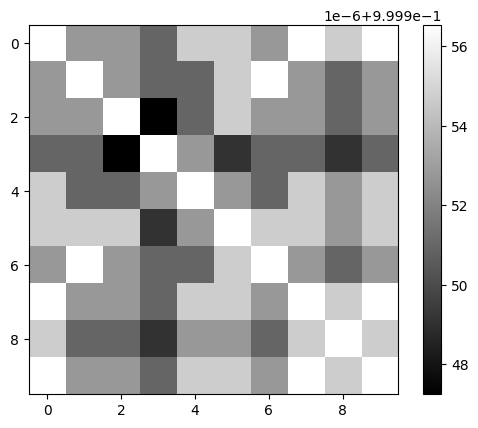

In [35]:
SM = tract_shape_dice(outputs[0],batch_size)
# print(SM)
SM1 = tract_shape_dice(eval_data,batch_size)
# print(SM-SM1)
plt.imshow((SM).cpu(),cmap='gray')
plt.colorbar()